Capstone Project Deteksi Sampah (Bangkit 2024 Batch 1)

1. Import Required Libray

In [ ]:
!pip install split-folders
!pip install opencv-python-headless

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import splitfolders
from tensorflow import keras
from keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from sklearn import metrics

2. Load and Split Dataset

In [11]:
dataset_path = "/content/drive/MyDrive/Gambar Sampah"

In [12]:
class_names = sorted(os.listdir(dataset_path))
print(class_names)

['kaca', 'karton', 'kertas', 'logam', 'organik', 'plastik']


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
class_dis = [len(os.listdir(dataset_path + f"/{name}")) for name in class_names]
class_dis

[453, 404, 610, 411, 420, 550]

In [14]:
splitfolders.ratio(dataset_path,
                   output="data_sampah",
                   seed=42,
                   ratio=(.7, .2, .1),
                   group_prefix=None)

Copying files: 2848 files [01:14, 38.38 files/s] 


In [15]:
training = os.path.join('data_sampah', 'train')
validation = os.path.join('data_sampah', 'val')
testing = os.path.join('data_sampah', 'test')

Dataset Augmentation

In [16]:
train_gen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.5,
                                   rotation_range = 40,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.3,
                                   fill_mode ='nearest',
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   brightness_range = [0.7, 1.3],
                                   channel_shift_range = 30.0
                                  )

valid_gen = ImageDataGenerator(rescale = 1.0 / 255.0)

test_gen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [17]:
train_images = train_gen.flow_from_directory(
    training,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
)

val_images = valid_gen.flow_from_directory(
    validation,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
)

test_images = test_gen.flow_from_directory(
    testing,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 1926 images belonging to 6 classes.
Found 547 images belonging to 6 classes.
Found 279 images belonging to 6 classes.


3. Build Model with CNN

In [18]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = True
for layer in pretrained_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

inputs = pretrained_model.input
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

9406464/9406464 [==============================] - 1s 0us/step


In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

Training Model

In [20]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
            print("\nAkurasi pelatihan dan validasi di atas 95%, menghentikan pelatihan!")
            self.model.stop_training = True

callbacks = [
    CustomCallback()
]

history = model.fit(
    train_images,
    epochs=50,
    validation_data=val_images,
    callbacks=callbacks
)


Epoch 1/50
61/61 [==============================] - 199s 3s/step - loss: 5.5507 - accuracy: 0.4865 - val_loss: 5.2686 - val_accuracy: 0.5466
Epoch 2/50
61/61 [==============================] - 200s 3s/step - loss: 4.8261 - accuracy: 0.6937 - val_loss: 5.1114 - val_accuracy: 0.5448
Epoch 3/50
61/61 [==============================] - 190s 3s/step - loss: 4.5421 - accuracy: 0.7368 - val_loss: 4.9500 - val_accuracy: 0.5704
Epoch 4/50
61/61 [==============================] - 176s 3s/step - loss: 4.2587 - accuracy: 0.7814 - val_loss: 4.5018 - val_accuracy: 0.6654
Epoch 5/50
61/61 [==============================] - 202s 3s/step - loss: 4.0449 - accuracy: 0.7871 - val_loss: 4.1821 - val_accuracy: 0.7112
Epoch 6/50
61/61 [==============================] - 175s 3s/step - loss: 3.8387 - accuracy: 0.7908 - val_loss: 4.0972 - val_accuracy: 0.7002
Epoch 7/50
61/61 [==============================] - 192s 3s/step - loss: 3.5949 - accuracy: 0.8307 - val_loss: 3.7212 - val_accuracy: 0.7587
Epoch 8/50
61

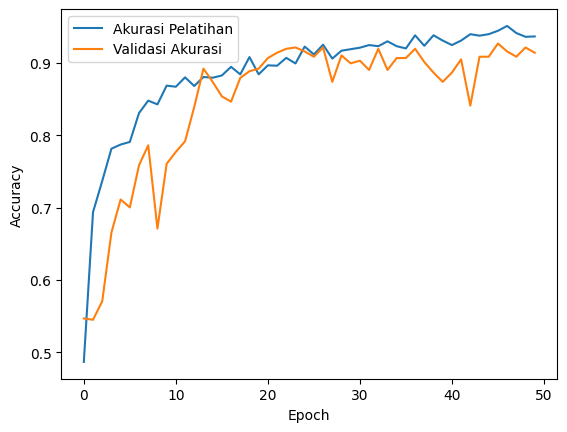

In [21]:
plt.plot(history.history["accuracy"], label="Akurasi Pelatihan")
plt.plot(history.history["val_accuracy"], label="Validasi Akurasi")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

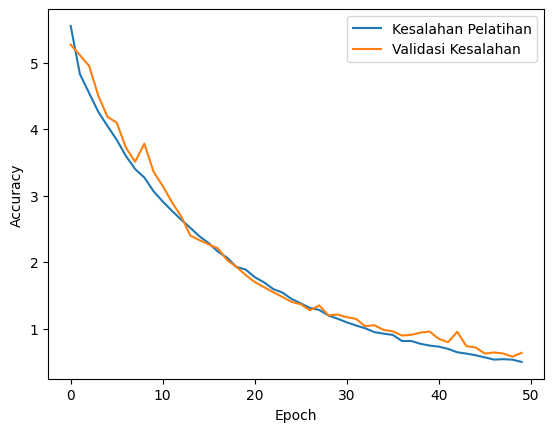

In [22]:
plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step


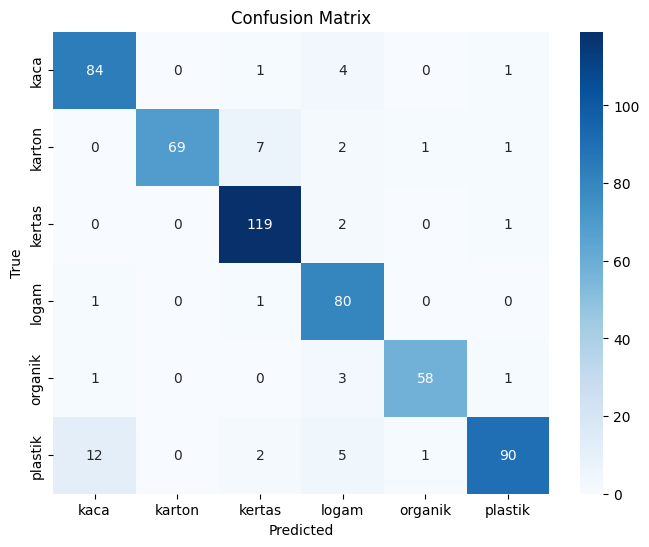

Classification Report:
               precision    recall  f1-score   support

        kaca       0.86      0.93      0.89        90
      karton       1.00      0.86      0.93        80
      kertas       0.92      0.98      0.94       122
       logam       0.83      0.98      0.90        82
     organik       0.97      0.92      0.94        63
     plastik       0.96      0.82      0.88       110

    accuracy                           0.91       547
   macro avg       0.92      0.91      0.91       547
weighted avg       0.92      0.91      0.91       547



In [23]:
true_labels = []
predicted_labels = []

for _ in range(len(val_images)):
    batch_images, batch_labels = next(val_images)
    predictions = model.predict(batch_images)
    true_labels.extend(np.argmax(batch_labels, axis=1))
    predicted_labels.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", classification_rep)

In [39]:
from google.colab import output
from IPython.display import display, Javascript, Image
from base64 import b64decode
import cv2
import numpy as np
import tensorflow as tf
from keras.preprocessing import image

dataset = pd.read_csv("datasetnew.csv", delimiter=';')

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        takePhoto({quality});
    ''')
    display(js)
    data = output.eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

photo_filename = take_photo()

preprocessed_image = preprocess_image(photo_filename)

predictions = model.predict(preprocessed_image)

predicted_class = np.argmax(predictions)

class_indices = train_images.class_indices
class_names = list(class_indices.keys())
predicted_class_name = class_names[predicted_class]
print(f'Sampah {predicted_class_name}')

for index, row in dataset.iterrows():
    if row['nama'] == predicted_class_name:
        print(f"Jenis Sampah: {row['jenis']}")
        print(f"Cara Penanganan: {row['cara_penanganan']}")
        print(f"Deskripsi: {row['deskripsi']}")


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 55ms/step
Sampah organik
Jenis Sampah: organik
Cara Penanganan: Kompos, sampah organik bisa dicampur dengan bahan organik lain untuk membuat kompos yang kaya akan nutrisi tanah, Pakan Ternak,  sampah organik bisa digunakan sebagai pakan ternak seperti ayam atau ikan, Pengkondisian Tanah, sampah organik seperti kulit telur dan cangkang kerang bisa dihancurkan dan ditaburkan di tanah untuk meningkatkan kadar kalsium, Penghilang Bau, sampah organik bisa dicampur dengan bahan organik lain untuk membuat kompos atau digunakan sebagai penghilang bau, Pupuk Kandang,sampah organik bisa difermentasi menjadi pupuk kandang yang berguna untuk tanaman, Biogas,sampah organik bisa digunakan sebagai bahan baku untuk menghasilkan biogas
Deskripsi: Sampah organik adalah sampah yang berasal dari tumbuhan dan hewan seperti sisa makanan, daun kering, kulit buah, dan sayuran yang sudah tidak terpakai.


4. Model Evaluation

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
  f.write(tflite_model)

In [ ]:
model.save("model.h5")
print("Keras model saved as 'model.h5'")